In [11]:
import pandas as pd
import tensorflow as tf
import pmo_forcasting.forecasting.lstm.recursive as fr
from pmo_forcasting.core.settings import settings
from pmo_forcasting.data.handler import DataHandler
import pmo_forcasting.forecasting.data_preparation as dp

In [2]:
MODEL_PATH = model_path = settings.paths.MODELS["models_dir"] / "best_models" / "model.keras"

lstm_model = tf.keras.models.load_model(MODEL_PATH)
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,037 (343.90 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 58,692 (229.27 KB)

In [3]:
df = DataHandler.from_registry(
    "DATA", "processed_dir", "processed_prices_data.csv").load()
# Filter for TSLA only
df = df[df['ticker'] == 'TSLA'].copy()
df.reset_index(drop=True, inplace=True)

In [7]:
# 1. Run the new preparation function
config = settings.config
prep = dp.prepare_forecasting_data(df, config)

# 3. Extract LSTM data (Pre-built 3D sequences, scaled 0-1)
X_train_lstm = prep["X_train_lstm"]
y_train_lstm = prep["y_train_lstm"]
X_test_lstm = prep["X_test_lstm"]
y_test_lstm = prep["y_test_lstm"]

# 4. Create your bundle
data_bundle = {

    "lstm_train": (X_train_lstm, y_train_lstm),
    "lstm_test": (X_test_lstm, y_test_lstm),
    "scaler": prep["scaler"],
    "test_index": prep["test_index"]  # Crucial for plotting later
}

print("Data ready ✔")

Data ready ✔


In [8]:
X_train_lstm, y_train_lstm = data_bundle["lstm_train"]
X_test_lstm, y_test_lstm = data_bundle["lstm_test"]
scaler = data_bundle["scaler"]
test_index = data_bundle["test_index"]

print(X_train_lstm.shape, X_test_lstm.shape)

(2456, 60, 1) (259, 60, 1)


In [9]:
# Window size inferred from test data
window_size = X_test_lstm.shape[1]

# Last available window
last_window = X_test_lstm[-1].reshape(1, window_size, 1)

##### Generate 6–12 month forecast

In [10]:
N_FORECAST_DAYS = settings.config["forecasting"]["lstm"]["forecasting_days"]

forecast_scaled = fr.recursive_lstm_forecast(
    model=lstm_model,
    seed_window=last_window,
    n_steps=N_FORECAST_DAYS
)

forecast_prices = fr.inverse_scale_forecast(
    forecast_scaled,
    scaler=data_bundle["scaler"]
)

In [12]:
last_date = data_bundle["test_index"][-1]

forecast_index = fr.build_forecast_index(
    last_date=last_date,
    n_steps=N_FORECAST_DAYS
)

lstm_forecast = pd.Series(
    forecast_prices,
    index=forecast_index,
    name="TSLA_LSTM_Forecast"
)

In [13]:
# Test predictions 
y_test_true = data_bundle["scaler"].inverse_transform(
    y_test_lstm.reshape(-1, 1)
).flatten()

test_preds = data_bundle["scaler"].inverse_transform(
    lstm_model.predict(X_test_lstm).reshape(-1, 1)
).flatten()

residuals = y_test_true - test_preds

lower_ci, upper_ci = fr.compute_confidence_intervals(
    forecast=lstm_forecast,
    residuals=residuals
)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


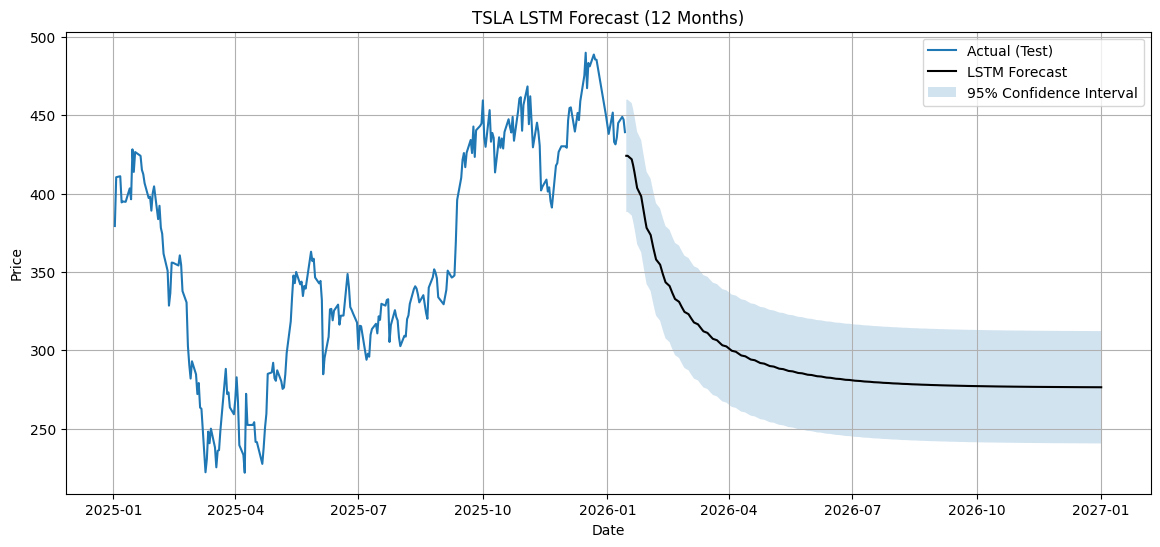

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Test actuals
plt.plot(
    test_index,
    y_test_true.flatten(),
    label="Actual (Test)"
)

# LSTM forecast
plt.plot(
    lstm_forecast.index,
    lstm_forecast.values,
    label="LSTM Forecast",
    color="black"
)

# Confidence interval
plt.fill_between(
    lstm_forecast.index,
    lower_ci,
    upper_ci,
    alpha=0.2,
    label="95% Confidence Interval"
)

plt.title("TSLA LSTM Forecast (12 Months)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
pct_change = (
    (lstm_forecast.iloc[-1] / lstm_forecast.iloc[0]) - 1
) * 100

trend = "Upward" if pct_change > 0 else "Downward"

print(f"""
Trend Analysis
--------------
Direction: {trend}
Start Price: {lstm_forecast.iloc[0]:.2f}
End Price: {lstm_forecast.iloc[-1]:.2f}
Expected Change: {pct_change:.2f}%
""")


Trend Analysis
--------------
Direction: Downward
Start Price: 424.09
End Price: 276.40
Expected Change: -34.82%



- The LSTM forecast indicates a downward trend for TSLA over the forecast horizon, with an expected decline of approximately 35%. This behavior reflects the model’s sensitivity to recent volatility and sustained negative price movements observed in the training period.

- Unlike ARIMA, which captures linear dependencies, the LSTM learns nonlinear temporal patterns and regime persistence. As a result, the forecast emphasizes trend continuation rather than mean reversion. This makes the model particularly responsive to prolonged drawdowns, which were prominent in TSLA’s recent price history.